### Distinguish indoor and outdoor sensors

In [1]:
import pandas as pd

sensor_info_df = pd.read_csv('sensor_info.csv')

def is_indoor_sensor(model):
    if 'PA-I' in model and 'PA-II' not in model:
        return 1
    else:
        return 0

sensor_info_df['is_indoor'] = sensor_info_df['model'].apply(is_indoor_sensor)

### Read in and process air_quality data

In [2]:
air_df = pd.read_csv('0605_full_purple_air_quality.csv')

In [3]:
air_df.head(5)

,time_stamp,sensor_index,humidity,temperature,visual_range,pm2.5_atm,pm2.5_aqi,datetime
0,1680307200,165783,48.433,63.734,114.0,11.1570,46.487500,4/1/2023 0:00
1,1680307200,140378,12.166,94.700,144.2,5.9030,24.595833,2023-04-01 00:00:00
2,1680307200,29183,100.000,-231.000,63.2,22.2755,72.399120,2023-04-01 00:00:00
3,1680307200,43527,20.733,87.000,262.0,1.2950,5.395833,2023-04-01 00:00:00
4,1680307200,175215,NaN,NaN,NaN,27.7050,83.817382,2023-04-01 00:00:00


Test if there are duplicated rows.

In [4]:
air_df = pd.read_csv('0605_full_purple_air_quality.csv')
duplicate_count = air_df.duplicated(subset=['time_stamp', 'sensor_index']).sum()
air_df.drop_duplicates(subset=['time_stamp', 'sensor_index'], inplace=True)
print(f'Total number of duplicate rows based on time_stamp and sensor_index: {duplicate_count}')

Total number of duplicate rows based on time_stamp and sensor_index: 0


Transform all the datetime into YYYY-MM-DD HH:MM:SS

In [5]:
from datetime import datetime

In [6]:
def convert_timestamp_to_datetime(timestamp):
    return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

air_df['datetime'] = air_df['time_stamp'].apply(convert_timestamp_to_datetime)

In [7]:
air_df.head(5)

,time_stamp,sensor_index,humidity,temperature,visual_range,pm2.5_atm,pm2.5_aqi,datetime
0,1680307200,165783,48.433,63.734,114.0,11.1570,46.487500,2023-04-01 00:00:00
1,1680307200,140378,12.166,94.700,144.2,5.9030,24.595833,2023-04-01 00:00:00
2,1680307200,29183,100.000,-231.000,63.2,22.2755,72.399120,2023-04-01 00:00:00
3,1680307200,43527,20.733,87.000,262.0,1.2950,5.395833,2023-04-01 00:00:00
4,1680307200,175215,NaN,NaN,NaN,27.7050,83.817382,2023-04-01 00:00:00


### Statistical results of indoor and outdoor sensors

In [8]:
air_df['datetime'] = pd.to_datetime(air_df['datetime'])
air_df['hour'] = air_df['datetime'].dt.hour

merged_df = pd.merge(air_df, sensor_info_df[['sensor_index', 'is_indoor']], on='sensor_index')

grouped_df = merged_df.groupby(['is_indoor', 'hour']).mean().reset_index()

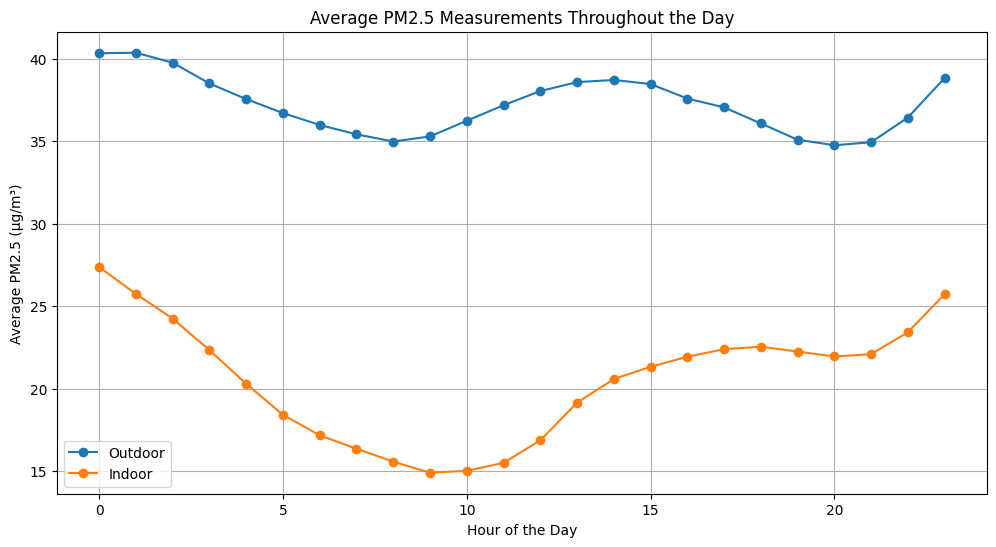

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for is_indoor in [0, 1]:
    subset = grouped_df[grouped_df['is_indoor'] == is_indoor]
    label = 'Indoor' if is_indoor == 1 else 'Outdoor'
    plt.plot(subset['hour'], subset['pm2.5_aqi'], marker='o', label=label)

plt.title('Average PM2.5 Measurements Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

Averagely, indoor sensors have significant smaller PM2.5 AQI data, and thus become not indicative. It should be removed.

In [10]:
sensor_info_df = sensor_info_df[sensor_info_df['is_indoor'] == 0].drop(columns=['is_indoor'])
air_df = air_df.drop(columns='hour')

outdoor_sensor_indices = sensor_info_df['sensor_index']
air_df = air_df[air_df['sensor_index'].isin(outdoor_sensor_indices)]

### Other columns

Delete other columns that aren't going to be considered in the model training.

In [11]:
air_df = air_df.drop(columns=['humidity', 'temperature', 'visual_range', 'pm2.5_atm'])

Null values detection.

In [12]:
print("Null values in sensor_info_df:")
print(sensor_info_df.isnull().sum())

print("Null values in air_df:")
print(air_df.isnull().sum())

Null values in sensor_info_df:
sensor_index    0
name            0
model           0
latitude        0
longitude       0
altitude        0
date_created    0
in_manhattan    0
dtype: int64
Null values in air_df:
time_stamp      0
sensor_index    0
pm2.5_aqi       0
datetime        0
dtype: int64


In [13]:
air_df.head(5)

,time_stamp,sensor_index,pm2.5_aqi,datetime
0,1680307200,165783,46.487500,2023-04-01
2,1680307200,29183,72.399120,2023-04-01
4,1680307200,175215,83.817382,2023-04-01
6,1680307200,147661,44.941667,2023-04-01
8,1680307200,49363,3.766667,2023-04-01


Average AQI results of each sensor.

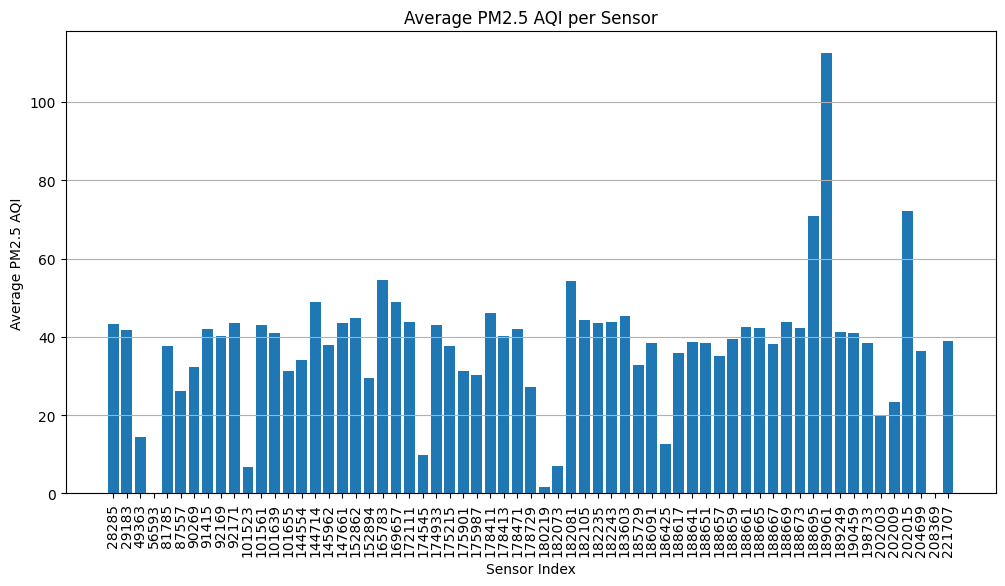

In [14]:
avg_aqi_per_sensor = air_df.groupby('sensor_index')['pm2.5_aqi'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(avg_aqi_per_sensor['sensor_index'].astype(str), avg_aqi_per_sensor['pm2.5_aqi'])
plt.xlabel('Sensor Index')
plt.ylabel('Average PM2.5 AQI')
plt.title('Average PM2.5 AQI per Sensor')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()

Some sensors have extremely low values.

In [15]:
sensors_below_10_aqi = avg_aqi_per_sensor[avg_aqi_per_sensor['pm2.5_aqi'] < 10]['sensor_index']

distribution_stats = []

for sensor in sensors_below_10_aqi:
    sensor_data = air_df[air_df['sensor_index'] == sensor]['pm2.5_aqi']
    stats = {
        'sensor_index': sensor,
        'mean': sensor_data.mean(),
        'max': sensor_data.max(),
        'min': sensor_data.min(),
        'Q1': sensor_data.quantile(0.25),
        'median': sensor_data.median(),
        'Q3': sensor_data.quantile(0.75),
        '97%':sensor_data.quantile(0.97)
    }
    distribution_stats.append(stats)

distribution_stats_df = pd.DataFrame(distribution_stats)

print(distribution_stats_df)

   sensor_index      mean         max  min        Q1    median         Q3  \
0         56593  0.020006   11.704167  0.0  0.000000  0.000000   0.000000   
1        101523  6.827317  133.618241  0.0  0.054167  1.279167   8.127083   
2        174545  9.772911  166.533620  0.0  0.291667  3.391667  11.770833   
3        180219  1.552165  126.694221  0.0  0.000000  0.000000   0.191667   
4        182073  7.072591  350.154354  0.0  0.162500  1.319792   5.830729   
5        208369  0.025902    3.156250  0.0  0.000000  0.000000   0.000000   

         97%  
0   0.086792  
1  40.432667  
2  53.241003  
3  13.108167  
4  58.146766  
5   0.157500  


Remove sensor 56593, 208369, as they have so small values and make us doubt their measurement environment.

In [16]:
indices_to_remove = [56593, 208369]
air_df = air_df[~air_df['sensor_index'].isin(indices_to_remove)]
sensor_info_df = sensor_info_df[~sensor_info_df['sensor_index'].isin(indices_to_remove)]

Save.

In [17]:
sensor_info_df.to_csv('sensor_info_processed.csv', index=False)
air_df.to_csv('air_quality_processed.csv', index=False)

Analysis

In [18]:
air_df.head(5)

,time_stamp,sensor_index,pm2.5_aqi,datetime
0,1680307200,165783,46.487500,2023-04-01
2,1680307200,29183,72.399120,2023-04-01
4,1680307200,175215,83.817382,2023-04-01
6,1680307200,147661,44.941667,2023-04-01
8,1680307200,49363,3.766667,2023-04-01


C:\Users\Legion\AppData\Local\Temp\ipykernel_6788\2383845312.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = air_df.resample('M', on='datetime')['pm2.5_aqi'].mean().reset_index()


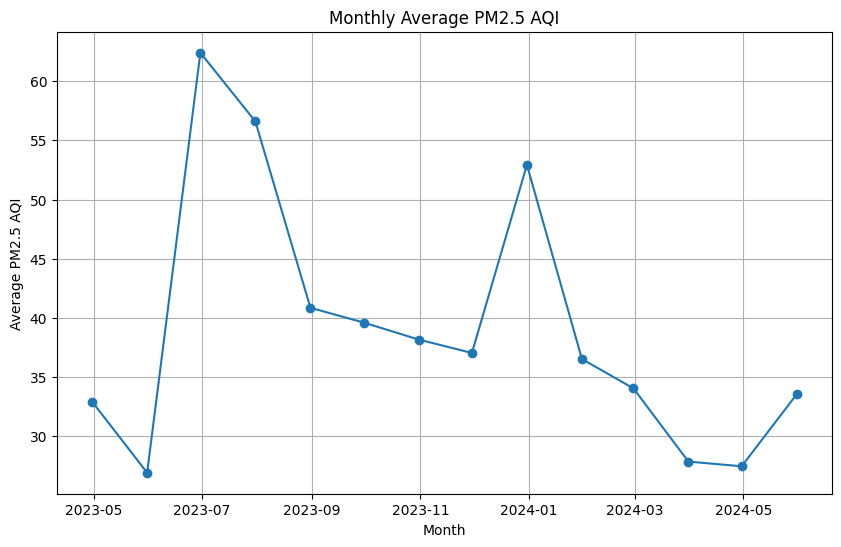

In [19]:
monthly_avg = air_df.resample('M', on='datetime')['pm2.5_aqi'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg['datetime'], monthly_avg['pm2.5_aqi'], marker='o')
plt.title('Monthly Average PM2.5 AQI')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 AQI')
plt.grid(True)
plt.show()

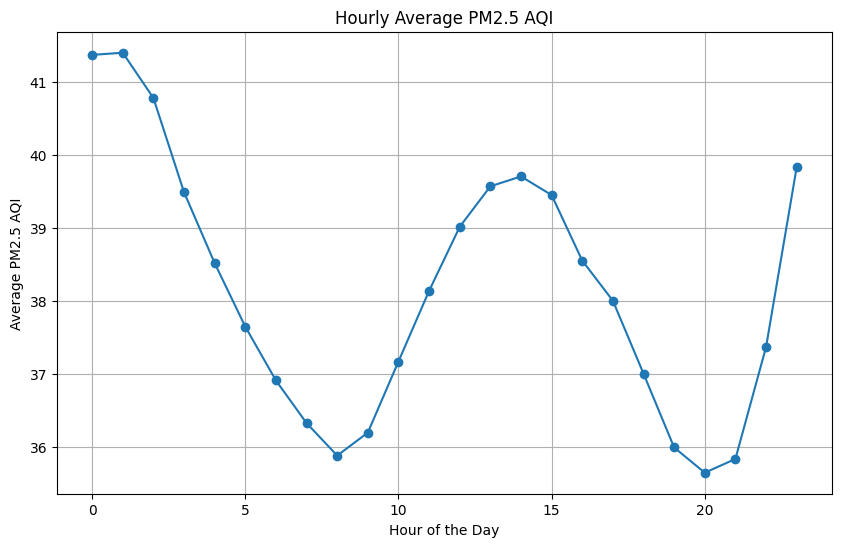

In [20]:
air_df['hour'] = air_df['datetime'].dt.hour
hourly_avg = air_df.groupby('hour')['pm2.5_aqi'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg['hour'], hourly_avg['pm2.5_aqi'], marker='o')
plt.title('Hourly Average PM2.5 AQI')
plt.xlabel('Hour of the Day')
plt.ylabel('Average PM2.5 AQI')
plt.grid(True)
plt.show()